In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# enhanced stats functions
from scipy import stats


In [2]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1
print(f"seaborn version : {sns.__version__}") # 0.11.2

pandas version  : 1.3.4
numpy version   : 1.20.3
seaborn version : 0.11.2


Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

In [3]:
SEED = 123
np.random.seed(SEED)

Importing the insurance dataset 

In [4]:
# read in data
import pandas as pd
ds = pd.read_csv('insurance.csv')

In [5]:
# checking the data is imported properly
ds.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [6]:
# conduct any other EDA that you need to in order to get a good feel for the data
ds.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



# Finding the median age of the individuals in our dataset

In [7]:
ds["age"].median()


39.0

In [8]:
ds["bmi"].idxmax()

1317


## finding Which two independent numeric variables (excluding categorical and dummy variables) are most highly correlated with each other?

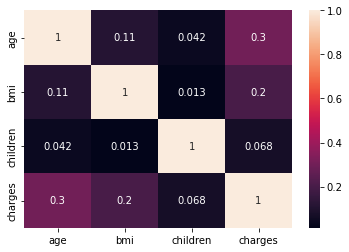

In [9]:

dataplot=sns.heatmap(ds.corr(),annot=True)

plt.show()


distribution of the `charges` variable in our dataset

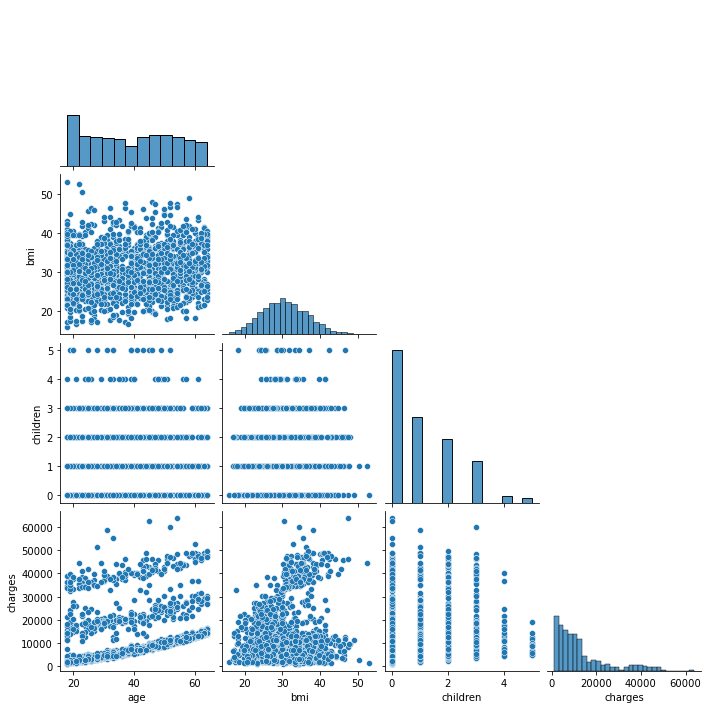

In [10]:
# plot distribution of charges
sns.pairplot(ds,corner=True)

In [11]:
# take log of charges, then drop old column
ds["log_charges"] = np.log(ds['charges'])

In [12]:
# check if your table matches the one above
ds.head(2)

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.90,0,yes,southwest,16884.9240,9.734176
1,18,male,33.77,1,no,southeast,1725.5523,7.453302


Great, now plot the new distribution to see whether it's a normal distribution.

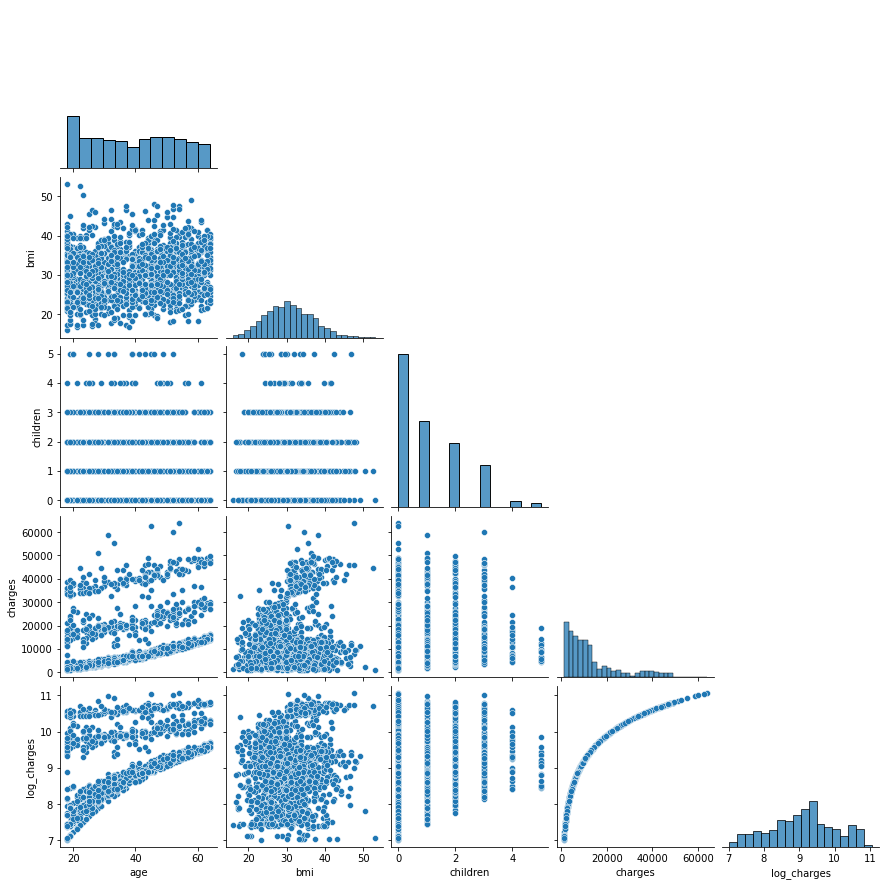

In [13]:
sns.pairplot(ds,corner=True)
plt.show()

In [14]:
# find indexes of duplicated rows
ds[ds.duplicated()]

,age,sex,bmi,children,smoker,region,charges,log_charges
581,19,male,30.59,0,no,northwest,1639.5631,7.402185


# Data Preprocessing
Now that we have an idea of what our data looks like, we need to start preparing it for modelling.

In this case, we don't have any missing data, so we don't need to do anything about that. We have one duplicated row, but that seems to be legitimate data, so we will keep it in. 

We have 3 categorical variables - sex, smoker, and region. Get dummy variables using pandas, ensuring to use the `drop_first=True` argument to mitigate possible multicollinearity issues. As a result, you should only have one dummy variable for binary values such as `sex` or `smoker`. 

In [15]:
Sex=pd.get_dummies(ds['sex'],drop_first=True)
ds=pd.concat([ds,Sex],axis=1)
ds.drop(columns=['sex'],inplace=True)



In [16]:
Smoker=pd.get_dummies(ds['smoker'],drop_first=True)
ds=pd.concat([ds,Smoker],axis=1)
ds.drop(columns=['smoker'],inplace=True)

In [17]:
Region=pd.get_dummies(ds['region'],drop_first=True)
ds=pd.concat([ds,Region],axis=1)
ds.drop(columns=['region'],inplace=True)

In [18]:
ds.head()

,age,bmi,children,charges,log_charges,male,yes,northwest,southeast,southwest
0,19,27.900,0,16884.92400,9.734176,0,1,0,0,1
1,18,33.770,1,1725.55230,7.453302,1,0,0,1,0
2,28,33.000,3,4449.46200,8.400538,1,0,0,1,0
3,33,22.705,0,21984.47061,9.998092,1,0,1,0,0
4,32,28.880,0,3866.85520,8.260197,1,0,1,0,0


Now verify that we still don't have major multicollinearity issues with a heatmap. What we're looking for is that most of the correlations between independent variables should still be relatively low. There's no single cut-off value (much of this is as much an art as it is a science), but we'll say for our purposes here that we'll consider anything between -0.5 and 0.5 to be low.

Note that if a variable is strongly correlated with our dependent variable `log_charges`, that's okay. If anything, that's probably a good thing!

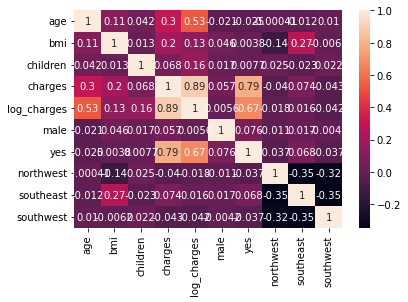

In [19]:
# correlation plot heatmap
dataplot=sns.heatmap(ds.corr(),annot=True)

plt.show()

In [20]:
# get number of independent variables
X = ds.iloc[:, :-1].values
print(X)

[[19.   27.9   0.   ...  1.    0.    0.  ]
 [18.   33.77  1.   ...  0.    0.    1.  ]
 [28.   33.    3.   ...  0.    0.    1.  ]
 ...
 [18.   36.85  0.   ...  0.    0.    1.  ]
 [21.   25.8   0.   ...  0.    0.    0.  ]
 [61.   29.07  0.   ...  1.    1.    0.  ]]


Now separating our independent variables into a variable called `X`, and our target variable `log_charges` into a variable called `y`.

In [21]:
X =ds[['age','bmi','children','male','yes','northwest','southeast','southwest']]
y = ds['log_charges']

In [22]:
# the resulting shapes of X and y should be (1338, 8) and (1338,) respectively
print(X.shape)
print(y.shape)

(1338, 8)
(1338,)


In [23]:
# do the train test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=123)

In [24]:
 #indexes for the first five data points in the training dataset after train_test_split
print(X_train[:5])

     age    bmi  children  male  yes  northwest  southeast  southwest
300   36  27.55         3     1    0          0          0          0
904   60  35.10         0     0    0          0          0          1
670   30  31.57         3     1    0          0          1          0
617   49  25.60         2     1    1          0          0          1
373   26  32.90         2     1    1          0          0          1


In [25]:
# instantiate linear regression model and fit the training data to it
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [26]:
# describing model
print(f"intercept: {lr.intercept_:.4f}")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {lr.coef_[i]:.4f}")

intercept: 6.9877
age: 0.0347
bmi: 0.0151
children: 0.1070
male: -0.0837
yes: 1.5320
northwest: -0.0879
southeast: -0.1546
southwest: -0.1433


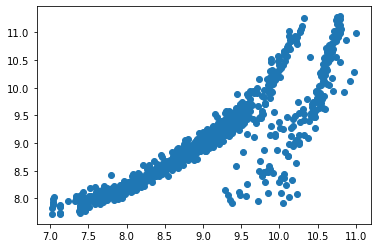

In [27]:
# predicting training set values
predictions_train = lr.predict(X_train)
plt.scatter(y_train,predictions_train)

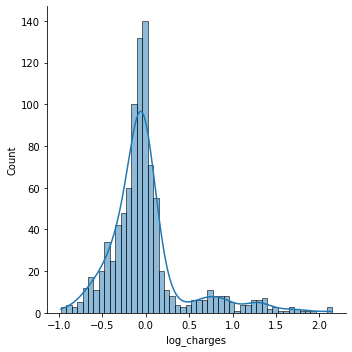

In [28]:
sns.displot((y_train-predictions_train),bins=50,kde=True)

In [29]:
# evaluate model R^2 (score)
r2_train = r2_score(y_train,predictions_train)
print(r2_train)

0.7607925391061419


In [30]:
# evaluate model MAE
mae_train = mean_absolute_error(y_train,predictions_train)

In [31]:
# evaluate model RMSE
rmse_train =np.sqrt(mean_squared_error(y_train,predictions_train))

In [32]:
# print metrics
print("metrics for training data")
print(f"R^2 score : {r2_train:.4f}")
print(f"mae       : {mae_train:.4f}")
print(f"rmse      : {rmse_train:.4f}")

metrics for training data
R^2 score : 0.7608
mae       : 0.2880
rmse      : 0.4557


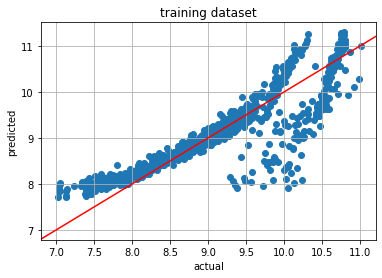

In [33]:
# plot predictions against actual values
plt.scatter(y_train, predictions_train)
plt.title("training dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

Clearly, while our model has clearly learned something about the data, there is still room for improvement.

Now we're going to evaluate our model's performance on the test set. First, we need to make our model predict the values for the test set.

In [34]:
# make predictions on test set
predictions_test = lr.predict(X_test)

In [35]:
# get same metrics as before - R^2, MAE, RMSE
r2_test =  r2_score(y_test,predictions_test)
mae_test = mean_absolute_error(y_test,predictions_test)
rmse_test = np.sqrt(mean_squared_error(y_test,predictions_test))

In [36]:
# printing metrics
print("metrics for test data")
print(f"R^2 score : {r2_test:.4f}")
print(f"mae       : {mae_test:.4f}")
print(f"rmse      : {rmse_test:.4f}")

metrics for test data
R^2 score : 0.7841
mae       : 0.2697
rmse      : 0.4129


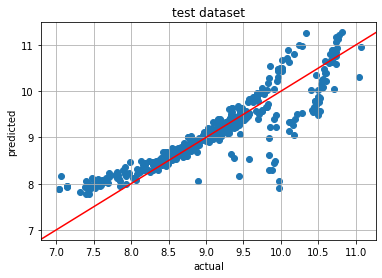

In [37]:
# plot predictions against actual values
plt.scatter(y_test, predictions_test)
plt.title("test dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

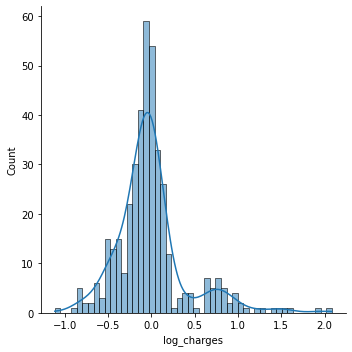

In [38]:
# plotting residuals to determine if they are normally distributed
sns.displot((y_test-predictions_test),bins=50,kde=True)

In [39]:
# getting predicted insurance charge for index 650
charge =np.exp(lr.predict(X_test))

In [40]:
# getting the predicted insurance charges
print(f"predicted insurance charges: {charge[0]:.2f}")

predicted insurance charges: 11995.36


intercept           : 6.9877
age                 : 0.0347
bmi                 : 0.0151
children            : 0.1070
male                : -0.0837
yes                 : 1.5320
northwest           : -0.0879
southeast           : -0.1546
southwest           : -0.1433
------------------------
Predicted insurance charges: 11995.36


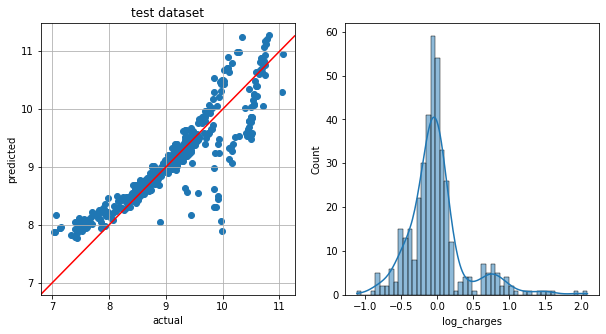

In [41]:
# describe model
print(f"{'intercept':<20}: {lr.intercept_:.4f}")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]:<20}: {lr.coef_[i]:.4f}")
print("---"*8)
# get predicted insurance charge for index 650
print(f"Predicted insurance charges: {charge[0]:.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,5)

# draw plots for test set
# ax1 - scatter plot of predictions vs actual
ax1.scatter(y_test, predictions_test)
ax1.axline([7, 7], [11, 11], color="red")
ax1.set_title("test dataset")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")
ax1.grid()
# ax2 - residuals plot
sns.histplot((y_test-predictions_test),bins=50,kde=True,ax=ax2)

plt.show()